# Analysis and Classification of The Bosphorus Database

TODO: Short description of dataset and the goal of the project

TODO: Describe data pre-processing steps to create the ``.csv`` file

## Load Dataset

In [1]:
import pandas as pd

data_df = pd.read_csv(r'../../data/lm3.csv')

## Visualize Dataset Format and Number of Features

TODO: description of the dataset format (i.e. each column represents a label in a particular dimension...)

In [2]:
print('Total number of features: \t%s' % len(data_df.columns.values))
data_df.head()

Total number of features: 	79


,Label,Outer left eyebrow-x,Outer left eyebrow-y,Outer left eyebrow-z,Middle left eyebrow-x,Middle left eyebrow-y,Middle left eyebrow-z,Inner left eyebrow-x,Inner left eyebrow-y,Inner left eyebrow-z,...,Lower lip outer middle-z,Chin middle-x,Chin middle-y,Chin middle-z,Left ear lobe-x,Left ear lobe-y,Left ear lobe-z,Right ear lobe-x,Right ear lobe-y,Right ear lobe-z
0,ANGER,-72.961,-1.725,22.958,-55.678,4.591,38.791,-31.920,-1.929,36.645,...,39.421,-9.840,-112.234,31.313,NaN,NaN,NaN,NaN,NaN,NaN
1,DISGUST,-76.565,-0.458,6.126,-62.086,9.454,24.055,-35.614,2.066,25.073,...,24.378,-13.583,-109.568,19.583,NaN,NaN,NaN,NaN,NaN,NaN
2,FEAR,-76.163,6.390,10.784,-57.083,16.865,30.162,-33.708,14.082,32.408,...,42.100,-13.020,-110.107,33.429,NaN,NaN,NaN,NaN,NaN,NaN
3,HAPPY,-72.140,8.896,9.353,-54.721,22.380,27.474,-29.789,15.802,28.937,...,38.018,-9.030,-97.687,36.058,NaN,NaN,NaN,NaN,NaN,NaN
4,SADNESS,-73.743,3.099,12.438,-58.607,15.144,29.381,-32.979,11.594,30.048,...,41.452,-10.731,-100.452,35.956,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleansing

#### Drop Features Where NaN Is Present

In [3]:
print('Total number of features before dropping NaN: \t%s' % len(data_df.columns.values))
data_df = data_df.dropna(axis=1, how='any')
print('Total number of features after dropping NaN: \t%s' % len(data_df.columns.values))
data_df.head()

Total number of features before dropping NaN: 	79
Total number of features after dropping NaN: 	58


,Label,Outer left eyebrow-x,Outer left eyebrow-y,Outer left eyebrow-z,Middle left eyebrow-x,Middle left eyebrow-y,Middle left eyebrow-z,Inner left eyebrow-x,Inner left eyebrow-y,Inner left eyebrow-z,...,Left mouth corner-z,Upper lip outer middle-x,Upper lip outer middle-y,Upper lip outer middle-z,Right mouth corner-x,Right mouth corner-y,Right mouth corner-z,Lower lip outer middle-x,Lower lip outer middle-y,Lower lip outer middle-z
0,ANGER,-72.961,-1.725,22.958,-55.678,4.591,38.791,-31.920,-1.929,36.645,...,31.654,-11.424,-77.828,44.218,7.849,-78.691,29.980,-9.891,-86.283,39.421
1,DISGUST,-76.565,-0.458,6.126,-62.086,9.454,24.055,-35.614,2.066,25.073,...,6.895,-15.941,-66.863,29.844,14.277,-75.678,7.290,-15.118,-83.790,24.378
2,FEAR,-76.163,6.390,10.784,-57.083,16.865,30.162,-33.708,14.082,32.408,...,25.992,-12.448,-60.169,45.930,9.749,-73.120,25.172,-12.362,-84.124,42.100
3,HAPPY,-72.140,8.896,9.353,-54.721,22.380,27.474,-29.789,15.802,28.937,...,17.507,-7.999,-51.207,40.242,22.196,-56.737,12.908,-7.063,-69.995,38.018
4,SADNESS,-73.743,3.099,12.438,-58.607,15.144,29.381,-32.979,11.594,30.048,...,25.140,-11.017,-62.101,42.409,14.146,-67.281,23.486,-9.479,-74.060,41.452


## Data Normalization

TODO: Describe why are we doing this

In [4]:
from sklearn.preprocessing import normalize

# Separate features from their labels
features = [x != 'Label' for x in data_df.columns.values]
all_values = data_df.loc[:, features].values
all_labels = data_df.loc[:,['Label']].values

# Scale values (mean = 0 and variance = 1)
all_values =  normalize(all_values, axis=0)

## Dimensionality Reduction

TODO: Describe what dimensionality reduction is and why is it necessary

#### PCA

TODO: Describe what PCA is

In [5]:
# Use PCA to reduce dimensionality
from sklearn.decomposition import PCA

pca = PCA(n_components = 15, whiten = True)
principal_components = pca.fit_transform(all_values)
principal_df = pd.DataFrame(data = principal_components)
# Add the label to the dataframe with the principal components
principal_labels_df = pd.concat([data_df[['Label']], principal_df], axis = 1)
principal_labels_df.head()

,Label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ANGER,0.115475,-1.625148,0.065469,0.114193,0.079739,1.031041,0.012079,-1.347167,0.986494,-1.195390,0.651152,0.667144,0.192260,-0.155829,1.118665
1,DISGUST,-0.073101,-1.483717,-0.133564,0.055333,-0.678214,0.639631,-0.328855,0.177782,-0.213121,-0.851841,-0.389660,0.403289,0.369033,-0.233596,0.912007
2,FEAR,0.061006,-1.113592,-0.500768,-0.805798,0.354913,0.951869,-0.296006,-0.947259,0.924113,-0.253905,0.758371,0.233441,0.275224,-0.997149,0.880709
3,HAPPY,0.122492,-0.808946,-0.375718,0.094078,-0.797231,0.172728,-1.712192,0.133741,-0.739601,-1.063692,0.370619,0.576226,0.477188,-0.323621,-0.051475
4,SADNESS,0.079619,-1.151237,-0.303649,-0.640826,-0.257518,0.543922,-1.133558,-0.789340,0.129232,-0.789671,0.986112,0.462523,-0.489619,-0.546546,0.819136


Visualize the PCA 2d projection

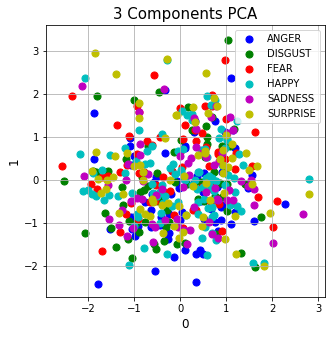

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
x_label = principal_labels_df.columns.values[1]
y_label = principal_labels_df.columns.values[2]
ax.set_xlabel(x_label, fontsize = 12)
ax.set_ylabel(y_label, fontsize = 12)
ax.set_title('3 Components PCA', fontsize = 15)

labels = np.unique(data_df.loc[:,['Label']].values)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for label, color in zip(labels, colors):
    indexes_to_keep = principal_labels_df['Label'] == label
    ax.scatter(
        principal_labels_df.loc[indexes_to_keep, x_label],
        principal_labels_df.loc[indexes_to_keep, y_label],
        c = color,
        s = 50
    )
ax.legend(labels)
ax.grid()
plt.show()

#### TSNE

TODO: Describe what TSNE is

In [7]:
from sklearn import manifold

tsne = manifold.TSNE(n_components = 15, init = 'pca', random_state = 0, method='exact')
tsne_components = tsne.fit_transform(all_values)
tsne_df = pd.DataFrame(data = tsne_components)
# Add the label to the dataframe with the TSNE components
tsne_labels_df = pd.concat([data_df[['Label']], tsne_df], axis = 1)
tsne_labels_df.head()

,Label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ANGER,2.366467,-5.952292,-5.817704,-0.516321,1.900749,-2.829597,-1.550068,-1.179924,2.064284,1.588390,1.871071,-0.678025,0.260862,6.342507,-0.145513
1,DISGUST,-0.553080,-8.393978,-5.530555,1.159727,3.700656,-4.151265,1.055790,-2.096505,4.206555,0.349276,3.538473,-1.545040,0.333859,0.354309,-1.023844
2,FEAR,27.137568,19.613581,-17.228455,0.163092,12.801679,11.829565,-3.108263,-16.574970,-30.612078,-0.751934,2.418499,-0.084304,-1.737079,1.558778,-0.953803
3,HAPPY,1.087585,-4.325572,-1.411307,-1.658222,0.399386,-1.429610,0.380368,4.122686,0.704613,0.050273,0.743142,-0.176219,0.150796,0.495435,7.570835
4,SADNESS,-0.581712,-7.353347,-2.013272,-3.199156,1.728881,-2.171417,-3.087746,-0.166789,1.612997,-0.269918,2.642377,0.811108,0.299304,1.669997,3.405343


Visualize the TSNE 2d projection

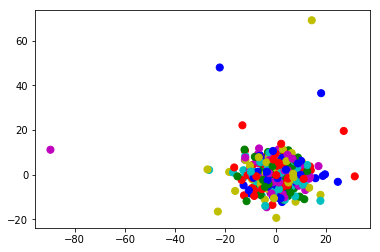

In [8]:
plt.scatter(tsne_components[:,0], tsne_components[:,1], c=colors, s=50)
plt.show()

## Label Distribution

TODO: Describe why this is important (i.e. make sure we train the models with the same number of samples per label)

In [9]:
rows, cols = tsne_labels_df.shape
print(tsne_labels_df.groupby('Label').count())
print('Total number of inputs: %s' % rows)

           0    1    2    3    4    5    6    7    8    9    10   11   12  \
Label                                                                       
ANGER      71   71   71   71   71   71   71   71   71   71   71   71   71   
DISGUST    69   69   69   69   69   69   69   69   69   69   69   69   69   
FEAR       70   70   70   70   70   70   70   70   70   70   70   70   70   
HAPPY     106  106  106  106  106  106  106  106  106  106  106  106  106   
SADNESS    66   66   66   66   66   66   66   66   66   66   66   66   66   
SURPRISE   71   71   71   71   71   71   71   71   71   71   71   71   71   

           13   14  
Label               
ANGER      71   71  
DISGUST    69   69  
FEAR       70   70  
HAPPY     106  106  
SADNESS    66   66  
SURPRISE   71   71  
Total number of inputs: 453


TODO: Explain output from above (i.e. from the table above we can see that some emotions have more samples than others, this is a problem because...)

#### Data Split

TODO: Describe how we are using holdout to account for class imbalance and the 80/20 partition as well

In [10]:
def get_train_test_split(df):
    '''
    Split data into training and test sets
    '''
    # Shuffle data frame
    df = df.sample(frac=1)
    
    # Select same number of samples per class for train set, remaining go to test set
    num_of_train_inputs = int(rows * 0.8 / 6)
    train_df, test_df = (pd.DataFrame(columns=df.columns.values), pd.DataFrame(columns=df.columns.values))
    labels = np.unique(df.loc[:,['Label']].values)
    for label in labels:
        train_df = train_df.append(df.loc[df['Label'] == label][0:num_of_train_inputs], ignore_index=True)
        test_df = test_df.append(df.loc[df['Label'] == label][num_of_train_inputs:], ignore_index=True)

    # Shuffle data frames (becuase they were appended in a per label fashion)
    train_df = train_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    
    # Split train and test datasets into labels/features
    train_values   = train_df.iloc[:,1:].values
    train_labels = train_df.iloc[:,:1].values.ravel()

    test_values   = test_df.iloc[:,1:].values
    test_labels = test_df.iloc[:,:1].values.ravel()
    
    return (train_values, train_labels, test_values, test_labels)

## Methods

#### k-Nearest Neighbors (kNN)

TODO: Describe what kNN is and its hyper-parameters

TODO: Explain choice of hyper-parameters (``n_neighbors``)

TODO: In the experiments below, we also need to print the confusion matrix and confidence scores (for both the PCA and TSNE)

Create a kNN model using the PCA components

In [11]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

# Get train/test values and labels using the PCA components
train_values, train_labels, test_values, test_labels = get_train_test_split(principal_labels_df)

kNNClassifier = neighbors.KNeighborsClassifier(n_neighbors=15).fit(train_values, train_labels)
predicted_labels = kNNClassifier.predict(test_values)
knn_pca_acc = accuracy_score(test_labels, predicted_labels)
print('kNN classifier accuracy using PCA components: \t%.02f%%' % knn_pca_acc)

kNN classifier accuracy using PCA components: 	0.63%


Create a kNN model using the TSNE components

In [12]:
# Get train/test values and labels using the TSNE components
train_values, train_labels, test_values, test_labels = get_train_test_split(tsne_labels_df)

kNNClassifier = neighbors.KNeighborsClassifier(n_neighbors=15).fit(train_values, train_labels)
predicted_labels = kNNClassifier.predict(test_values)
knn_tsne_acc = accuracy_score(test_labels, predicted_labels)
print('kNN classifier accuracy using TSNE components: \t%.02f%%' % knn_tsne_acc)

kNN classifier accuracy using TSNE components: 	0.27%


#### Support Vector Machine (SVM)

TODO: Describe what SVM is

TODO: In the experiments below, we also need to print the confusion matrix and confidence scores (for both the PCA and TSNE)

Create a SVM model using the PCA components

In [33]:
from sklearn.svm import LinearSVC

# Get train/test values and labels using the PCA components
train_values, train_labels, test_values, test_labels = get_train_test_split(principal_labels_df)

svm = LinearSVC()
svm.fit(train_values, train_labels)
predicted_labels = svm.predict(test_values)
svm_pca_acc = accuracy_score(test_labels, predicted_labels)
print('SVM classifier accuracy using PCA components: \t%.02f%%' % svm_pca_acc)

SVM classifier accuracy using PCA components: 	0.80%


Create a SVM model using the TSNE components

In [14]:
# Get train/test values and labels using the TSNE components
train_values, train_labels, test_values, test_labels = get_train_test_split(tsne_labels_df)

svm = LinearSVC()
svm.fit(train_values, train_labels)
predicted_labels = svm.predict(test_values)
svm_tsne_acc = accuracy_score(test_labels, predicted_labels)
print('SVM classifier accuracy using TSNE components: \t%.02f%%' % svm_tsne_acc)

SVM classifier accuracy using TSNE components: 	0.24%


#### Multilayer Perceptron (MLP)

TODO: Describe what a MLP is

TODO: Explain choice of hyper-parameters (``solver``, ``activation``, ``hidden_layer_sizes``, ``max_iter``, and ``batch_size``) 

TODO: In the experiments below, we also need to print the confusion matrix and confidence scores (for both the PCA and TSNE)

Create a MLP model using the PCA components

In [43]:
from sklearn.neural_network import MLPClassifier

# Get train/test values and labels using the PCA components
train_values, train_labels, test_values, test_labels = get_train_test_split(principal_labels_df)

mlp = MLPClassifier(solver='adam', activation='identity', hidden_layer_sizes=18, 
                    max_iter=300, batch_size=64)
mlp.fit(train_values, train_labels)
predicted_labels = mlp.predict(test_values)
mlp_pca_acc = accuracy_score(test_labels, predicted_labels)
print('MLP classifier accuracy using PCA components: \t%.02f%%' % mlp_pca_acc)

MLP classifier accuracy using PCA components: 	0.83%


Create a MLP model using the TSNE components

In [16]:
# Get train/test values and labels using the PCA components
train_values, train_labels, test_values, test_labels = get_train_test_split(tsne_labels_df)

mlp = MLPClassifier(solver='adam', activation='identity', hidden_layer_sizes=18, 
                    max_iter=300, batch_size=64)
mlp.fit(train_values, train_labels)
predicted_labels = mlp.predict(test_values)
mlp_tsne_acc = accuracy_score(test_labels, predicted_labels)
print('MLP classifier accuracy using TSNE components: \t%.02f%%' % mlp_tsne_acc)

MLP classifier accuracy using TSNE components: 	0.19%


#### Random Forest

TODO: Describe what a Random Forest is

TODO: Explain choice of hyper-parameters (``n_estimators``, ``n_jobs``, ``criterion``, and ``max_features``) 

TODO: In the experiments below, we also need to print the confusion matrix and confidence scores (for both the PCA and TSNE)

Create a Random Forest model using the PCA components

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Get train/test values and labels using the PCA components
train_values, train_labels, test_values, test_labels = get_train_test_split(principal_labels_df)

random_forest = RandomForestClassifier(n_estimators=10, n_jobs=1, criterion='gini', max_depth=6, max_features='sqrt')
random_forest.fit(train_values, train_labels)
predicted_labels = random_forest.predict(test_values)
random_forest_pca_acc = accuracy_score(test_labels, predicted_labels)
print('Random Forest classifier accuracy using PCA components: \t%.02f%%' % random_forest_pca_acc)

Random Forest classifier accuracy using PCA components: 	0.61%


Create a Random Forest model using the TSNE components

In [18]:
# Get train/test values and labels using the PCA components
train_values, train_labels, test_values, test_labels = get_train_test_split(tsne_labels_df)

random_forest = RandomForestClassifier(n_estimators=10, n_jobs=1, criterion='gini', max_depth=6, max_features='sqrt')
random_forest.fit(train_values, train_labels)
predicted_labels = random_forest.predict(test_values)
random_forest_tsne_acc = accuracy_score(test_labels, predicted_labels)
print('Random Forest classifier accuracy using TSNE components: \t%.02f%%' % random_forest_tsne_acc)

Random Forest classifier accuracy using TSNE components: 	0.24%


## Conclusion

TODO: Summary of our work and what configuration (model, PCA/TSNE, etc) produced the best results

In [44]:
pca_models = {
    'kNN with PCA': knn_pca_acc,
    'SVM with PCA': svm_pca_acc,
    'MLP with PCA': mlp_pca_acc,
    'Random Forest with PCA': random_forest_pca_acc
}

for model, acc in pca_models.items():
    print('%s classifier accuracy: \t%.02f%%' % (model, acc))

kNN with PCA classifier accuracy: 	0.63%
SVM with PCA classifier accuracy: 	0.80%
MLP with PCA classifier accuracy: 	0.83%
Random Forest with PCA classifier accuracy: 	0.61%


In [45]:
tsne_models = {
    'kNN with TSNE': knn_tsne_acc,
    'SVM with TSNE': svm_tsne_acc,
    'MLP with TSNE': mlp_tsne_acc,
    'Random Forest with TSNE': random_forest_tsne_acc
}
    
for model, acc in tsne_models.items():
    print('%s classifier accuracy: \t%.02f%%' % (model, acc))

kNN with TSNE classifier accuracy: 	0.27%
SVM with TSNE classifier accuracy: 	0.24%
MLP with TSNE classifier accuracy: 	0.19%
Random Forest with TSNE classifier accuracy: 	0.24%
